In [1]:
!pip install --quiet quandl plotly git+https://github.com/ethho/memoize.git lmfit

In [63]:
import json
import re
import os
from glob import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from joblib import Parallel, delayed
import functools
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import quandl
import plotly.express as px
import plotly.graph_objects as go
from memoize.dataframe import memoize_df
from lmfit.models import SkewedGaussianModel

%matplotlib inline
# pd.options.display.float_format = '{:,.4f}'.format

DARK_MODE = True
if DARK_MODE:
    plt.style.use('dark_background')
    plotly_template = 'plotly_dark'
else:
    plt.style.use('ggplot')
    plotly_template = 'ggplot2'

# 20230222_final_proj

@mpcs
@finm33550

Ethan Ho 2/22/2023

----

## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [58]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

def strip_str_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame, strips values in columns with string or object
    dtype. I noticed that this was an issue when I saw some m_ticker values
    like "AAPL       " with trailing whitespace.
    """
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].str.strip()
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_table(
    name, start_date, end_date, **kw
) -> pd.DataFrame:
    df = quandl.get_table(
        name,
        date={'gte': start_date, 'lte': end_date},
        api_key=get_quandl_api_key(),
        paginate=True,
        **kw
    )
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    df.reset_index(inplace=True)
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_quotemedia_prices(
    start_date, end_date, ticker
) -> pd.DataFrame:
    return fetch_quandl_table(
        name= 'QUOTEMEDIA/PRICES',
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
    )

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_yc(
    name, start_date, end_date,
) -> pd.DataFrame:
    df = quandl.get(
        name,
        start_date=start_date,
        end_date=end_date,
        api_key=get_quandl_api_key(),
    ).reset_index().rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_spot(
    symbol, **kw
) -> pd.DataFrame:
    df = quandl.get(
        f'CUR/{symbol}',
        **kw
    ).reset_index().rename(columns={
        'DATE': 'date',
        'RATE': f'USD/{symbol}',
    })
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

def unique_index_keys(df, level=0) -> List[str]:
    return df.index.get_level_values(level=level).unique().tolist()

def get_next_day_of_week(date, day_of_week: int) -> str:
    """
    Monday = 0, Wednesday = 2
    """
    as_dt = pd.to_datetime(date)
    days_until = (day_of_week - as_dt.day_of_week) % 7
    out_dt = as_dt + pd.to_timedelta(days_until, 'D')
    return out_dt.strftime('%Y-%m-%d')

def get_standard_yc_cols(cols: List, col_prefix='') -> Dict:
    out = dict()
    for col_raw in cols:
        col = col_raw.lower()
        col = re.sub(r'-year', 'y', col)
        col = re.sub(r'-month', 'm', col)
        if col_prefix:
            col = col_prefix + '_' + col
        out[col_raw] = col
    return out

def get_yc(*args, col_prefix='', **kw):
    df = fetch_quandl_yc(*args, **kw)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.rename(columns=get_standard_yc_cols(df.columns, col_prefix), inplace=True)
    return df

@functools.lru_cache()
def get_col_groups(cols) -> Dict:
    """
    get_col_groups(tuple(yc_daily.columns.tolist()))
    """
    out = dict()
    for col in cols:
        prefix, tenor_raw = col.split('_')
        tenor, unit = tenor_raw[:-1], tenor_raw[-1]
        if prefix not in out:
            out[prefix] = list()
        item = {
            'col': col,
            'country': prefix,
            'tenor': tenor,
            'unit': unit
        }
        out[prefix].append(item)
    return out

def bond_price(zcb, coupon_rate, tenor, coupon_freq):
    """
    Adapted from Zero_And_Spot_Curves.ipynb
    """
    times = np.arange(tenor, 0, step=-coupon_freq)[::-1]
    if times.shape[0] == 0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + coupon_freq * coupon_rate * np.exp(-r*times).sum()
    return p

def get_zcb_curve(spot, coupons_per_year=2, holding_period=30/360.):
    """
    Adapted from Zero_And_Spot_Curves.ipynb
    """
    cpn_freq = 1 / float(coupons_per_year)
    for tenor, spot_rate in spot.items():
        if tenor <= 0.001:
            continue
        if tenor <= 1.:
            # US T-bills (<=1 year maturity) have no coupons
            spot.loc[tenor] = spot_rate
        else:
            times = np.arange(tenor-cpn_freq, 0, step=-cpn_freq)[::-1]
            coupon_half_yr = cpn_freq * spot_rate
            z = np.interp(times, spot.index.values, spot.values) # Linear interpolation
            preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
            spot.loc[tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
        
    spot_copy = spot.copy()
    for tenor, spot_rate in spot.items():
        # Calculate bond price for maturities,
        # for example T = 5 years and S = 5 years - 1 week
        T = tenor
        S = T - holding_period
        tenor_name = str(int(tenor)) if tenor == int(tenor) else f"{tenor:0.2f}"
        spot.loc[f'{tenor_name}_rt'] = bond_price(spot_copy, coupon_rate=spot.loc[tenor], tenor=T, coupon_freq=cpn_freq)
        spot.loc[f'{tenor_name}_rs'] = bond_price(spot_copy, coupon_rate=spot.loc[tenor], tenor=S, coupon_freq=cpn_freq)
    return spot

def get_zcb_curves_135(row):
    # Get groups by column prefix
    grps: Dict[List[Dict]] = get_col_groups(tuple(row.columns.tolist()))
    zcb_dict = dict()
    for cty, cols in grps.items():
        df = pd.DataFrame.from_records(cols).convert_dtypes()
        df['tenor'] = df['tenor'].astype(int)
        df.set_index(['tenor', 'unit'], inplace=True)
        
        lo_col = df.loc[(1, 'y'), 'col']
        lo = row[lo_col]
        lo.name = 1
            
        mid_col = df.loc[(3, 'y'), 'col']
        mid = row[mid_col]
        mid.name = 3
        
        hi_col = df.loc[(5, 'y'), 'col']
        hi = row[hi_col]
        hi.name = 5
        
        zcb = (pd.concat([lo, mid, hi], axis=1) / 100).apply(get_zcb_curve, axis=1)
        holding_period = 30/360.
        for tenor in (lo.name, mid.name, hi.name):
            tenor_name = str(int(tenor)) if tenor == int(tenor) else f"{tenor:0.2f}"
            T = tenor
            S = tenor - holding_period
            rt = zcb[f"{tenor_name}_rt"]
            rs = zcb[f"{tenor_name}_rs"]
            zcb[f'{tenor_name}_val'] = (
                (np.exp(-rs * S) / np.exp(-rt.shift(1) * T))
            )
            # zcb[f'{tenor_name}_ret'] = (zcb[f'{tenor_name}_val'] - zcb[f'{tenor_name}_val'].shift(1)) / zcb[f'{tenor_name}_val'].shift(1)
        zcb.rename(columns={
            lo.name: f"{lo_col}_zcb",
            mid.name: f"{mid_col}_zcb",
            hi.name: f"{hi_col}_zcb",
        }, inplace=True)
        zcb_dict[cty] = zcb
    return zcb_dict

def get_zcb_curves_362(row):
    # Get groups by column prefix
    grps: Dict[List[Dict]] = get_col_groups(tuple(row.columns.tolist()))
    zcb_dict = dict()
    for cty, cols in grps.items():
        df = pd.DataFrame.from_records(cols).convert_dtypes()
        df['tenor'] = df['tenor'].astype(int)
        df.set_index(['tenor', 'unit'], inplace=True)
        
        lo_col = df.loc[(3, 'm'), 'col']
        lo = row[lo_col]
        lo.name = 0.25
            
        mid_col = df.loc[(6, 'm'), 'col']
        mid = row[mid_col]
        mid.name = 0.5
        
        hi_col = df.loc[(2, 'y'), 'col']
        hi = row[hi_col]
        hi.name = 2
        
        zcb = (pd.concat([lo, mid, hi], axis=1) / 100).apply(get_zcb_curve, axis=1)
        holding_period = 30/360.
        for tenor in (lo.name, mid.name, hi.name):
            tenor_name = str(int(tenor)) if tenor == int(tenor) else f"{tenor:0.2f}"
            T = tenor
            S = tenor - holding_period
            rt = zcb[f"{tenor_name}_rt"]
            rs = zcb[f"{tenor_name}_rs"]
            zcb[f'{tenor_name}_val'] = (
                (np.exp(-rs * S) / np.exp(-rt.shift(1) * T))
            )
            # zcb[f'{tenor_name}_ret'] = (zcb[f'{tenor_name}_val'] - zcb[f'{tenor_name}_val'].shift(1)) / zcb[f'{tenor_name}_val'].shift(1)
        zcb.rename(columns={
            lo.name: f"{lo_col}_zcb",
            mid.name: f"{mid_col}_zcb",
            hi.name: f"{hi_col}_zcb",
        }, inplace=True)
        zcb_dict[cty] = zcb
    return zcb_dict

def get_zcb_curves(row):
    zcb135_dict = get_zcb_curves_135(yc_monthly)
    zcb362_dict = get_zcb_curves_362(yc_monthly)
    zcb = {
        k: zcb135_dict[k].merge(zcb362_dict[k], how='outer', left_index=True, right_index=True)
        for k in zcb135_dict.keys()
    }
    return zcb

# Fetch Data

First, let's set our time indices. We choose to trade weekly on Wednesdays, and skip the week if the Wednesday falls on a holiday.

In [59]:
start_date = '1990-01-01'
end_date = '2022-12-16'

daily_idx = pd.date_range(start_date, end_date)
first_wed = get_next_day_of_week(start_date, 2)
wed_idx_w_holidays = pd.date_range(first_wed, end_date, freq='7D')
assert all(date.day_of_week == 2 for date in wed_idx_w_holidays)

wed_idx = [
    date for date in wed_idx_w_holidays
    if date not in pd.to_datetime([
        # Remove Wednesdays that fall on holidays
        '2012-12-26', '2013-12-25', '2014-01-01', '2018-12-26',
        '2019-12-25', '2020-01-01',
    ])
]
assert len(wed_idx_w_holidays) > len(wed_idx)

Next, we'll use modified versions of the HW5 functions to calculate zero-coupon rates for U.S. Treasury bonds of the following maturities. We plan to trade primarily these 6 assets for our project, which puts us above the 5-asset minimum:

- 3 month
- 6 month
- 1 year
- 2 year
- 3 year
- 5 year

We make the following assumptions about coupons:

- Coupons are not given for T-bills, i.e. bonds with maturity of 1 year or less.
- Coupon yield is the same as the current yield for the note that it is given for.
- Coupons are distributed semi-annually.

In [60]:
countries = {
    'USA': 'USD',
}

yc_dict = {
    country: (
        get_yc(f'YC/{country}', start_date=start_date, end_date=end_date, col_prefix=country.lower())
        .reindex(daily_idx)
        .fillna(method='ffill')
        .iloc[1:, :]
    ) for country in countries.keys()
}
yc_daily = pd.concat(yc_dict.values(), axis=1)
yc_monthly = yc_daily.loc[wed_idx].copy()
zcb = get_zcb_curves(yc_monthly)
uszcb = zcb['usa']
uszcb

Using cache fp='data/memoize/fetch_quandl_yc_7609035_20230222.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_7609035_20230222.csv


,usa_1y_zcb,usa_3y_zcb,usa_5y_zcb,1_rt,1_rs,3_rt,3_rs,5_rt,5_rs,1_val,...,usa_2y_zcb,0.25_rt,0.25_rs,0.50_rt,0.50_rs,2_rt,2_rs,0.25_val,0.50_val,2_val
1990-01-03,0.0785,0.077962,0.077529,0.998528,1.005081,0.995883,1.002321,0.993513,0.999891,NaN,...,0.077771,1.019148,1.025871,0.999233,1.005936,0.997120,1.003453,NaN,NaN,NaN
1990-01-10,0.0777,0.077909,0.077569,0.998557,1.005044,0.995998,1.002506,0.993663,1.000060,1.080299,...,0.077528,1.018818,1.025419,0.999263,1.005804,0.997218,1.003657,1.087502,1.083863,1.073112
1990-01-17,0.0791,0.079452,0.079438,0.998506,1.005110,0.995868,1.002518,0.993579,1.000177,1.080265,...,0.079249,1.019336,1.026129,0.999227,1.005885,0.997088,1.003652,1.087284,1.083842,1.073333
1990-01-24,0.0800,0.081229,0.081084,0.998473,1.005151,0.995826,1.002709,0.993400,1.000117,1.080169,...,0.080335,1.019242,1.026000,0.999223,1.005982,0.997066,1.003807,1.087448,1.083779,1.072735
1990-01-31,0.0808,0.081892,0.081749,0.998443,1.005188,0.995739,1.002663,0.993281,1.000053,1.080096,...,0.081079,1.019407,1.026225,0.999196,1.006170,0.996972,1.003718,1.087382,1.083692,1.072872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-16,0.0462,0.040708,0.037646,0.999481,1.003336,0.998389,1.001183,0.997137,0.999742,1.082991,...,0.042983,1.010626,1.014271,0.999746,1.003842,0.999035,1.002386,1.087187,1.085025,1.079781
2022-11-23,0.0475,0.041673,0.038095,0.999451,1.003415,0.998297,1.001137,0.996918,0.999474,1.082944,...,0.044053,1.010820,1.014533,0.999732,1.004006,0.998982,1.002401,1.087159,1.084954,1.079827
2022-11-30,0.0474,0.040672,0.037523,0.999454,1.003409,0.998291,1.000948,0.997034,0.999613,1.082918,...,0.043252,1.010747,1.014435,0.999728,1.004112,0.998978,1.002223,1.087229,1.084898,1.080082
2022-12-07,0.0467,0.039088,0.035540,0.999469,1.003367,0.998329,1.000753,0.997092,0.999431,1.082963,...,0.042055,1.010553,1.014173,0.999726,1.004265,0.998982,1.001990,1.087257,1.084827,1.080556


In [61]:
uszcb.columns

Index(['usa_1y_zcb', 'usa_3y_zcb', 'usa_5y_zcb', '1_rt', '1_rs', '3_rt',
       '3_rs', '5_rt', '5_rs', '1_val', '3_val', '5_val', 'usa_3m_zcb',
       'usa_6m_zcb', 'usa_2y_zcb', '0.25_rt', '0.25_rs', '0.50_rt', '0.50_rs',
       '2_rt', '2_rs', '0.25_val', '0.50_val', '2_val'],
      dtype='object')

A couple notes on notation here. Column prefixes denote the maturity. Column suffixes follow the conventions:

- `_zcb`: Zero-coupon yield. Same as the "dirty" yield for zero coupon bonds and T-bills.
- `_rs`: Bond price on the 0-month forward curve.
- `_rt`: Bond price on the 1-month forward curve.
- `_val`: Bond value assuming a 1-month holding period.

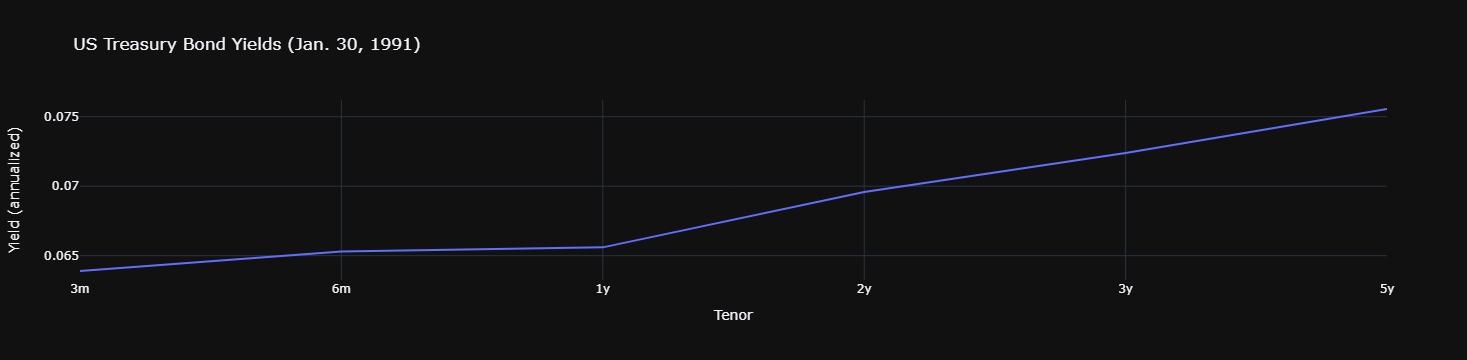

In [91]:
fig = px.line(
    uszcb.rename(columns={
        f'usa_{tenor}_zcb': tenor for tenor in [
            '3m', '6m', '1y', '2y', '3y', '5y'
        ]
    }).loc['1991-01-30', [
        # '0.25_val', '0.50_val', '1_val', '2_val', '3_val', '5_val'
        '3m', '6m', '1y', '2y', '3y', '5y'
    ]],
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'index': 'Tenor',
    },
    title="US Treasury Bond Yields (Jan. 30, 1991)",
)
fig.update_layout(showlegend=False)
fig

Note that the x axis in the above plot is not linear. We'll fix this in the full project, when we'll refactor the ZCB calculations into matrix math in numpy, so that the yield curve is just a 3-D matrix on continuous variables tenor, time, and yield.

Like the Carry Trade homework, many of our trades require additional funding. In Strategy 1-A, for instance, we would buy all maturities on the curve using funds borrowed at the 1-month T-bill rate (plus 50 basis points).

In [78]:
yc_monthly.loc['2001-07-31':, 'usa_1m']

2001-08-01    3.65
2001-08-08    3.61
2001-08-15    3.52
2001-08-22    3.46
2001-08-29    3.48
              ... 
2022-11-16    3.81
2022-11-23    4.12
2022-11-30    4.07
2022-12-07    3.79
2022-12-14    3.91
Name: usa_1m, Length: 1110, dtype: float64

1 month (4 week) T-bills were not issued before August 2001, as we can see from [this press release](https://home.treasury.gov/news/press-releases/po496). Therefore, we will study the period between August 2001 and January 2023 for our project, since this is the timescale for which we can fund the various mean-reversion strategies using 1-month T-bills.

# Strategy 1-A Preliminary Analysis

Mean yield of 1, 3, and 5-year rates:

In [81]:
mean_yield = uszcb[['usa_1y_zcb', 'usa_3y_zcb', 'usa_5y_zcb']].mean(axis=1)
mean_yield.head(3)

1990-01-03    0.077997
1990-01-10    0.077726
1990-01-17    0.079330
dtype: float64

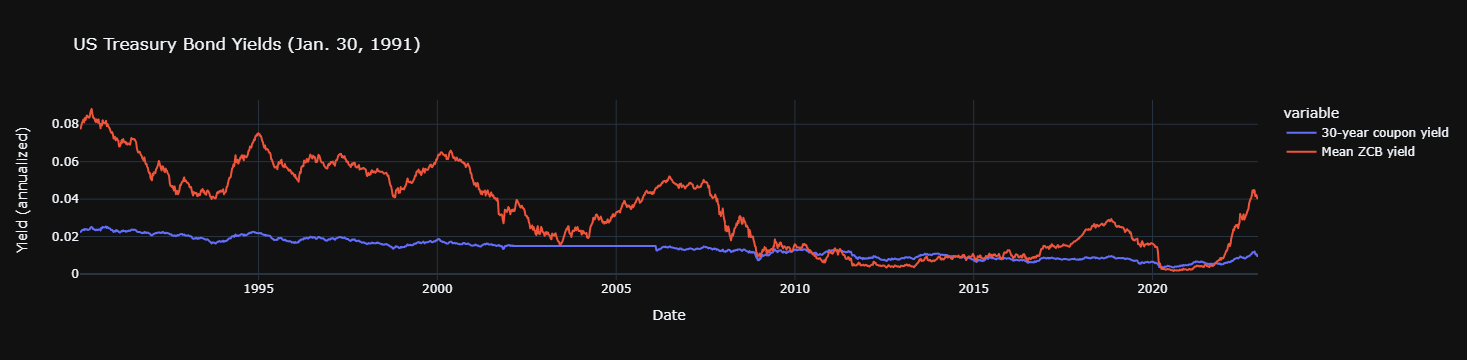

In [99]:
mean_vs_30_yc = (yc_monthly[['usa_30y']] / 360.).merge(
    mean_yield.to_frame('mean_zcb'),
    how='inner',
    left_index=True,
    right_index=True,
)
fig = px.line(
    mean_vs_30_yc.rename(columns={
        'usa_30y': '30-year coupon yield',
        'mean_zcb': 'Mean ZCB yield',
    }),
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'index': 'Date',
    },
    title="US Treasury Bond Yields (Jan. 30, 1991)",
)
# fig.update_layout(showlegend=False)
fig

In [100]:
mean_vs_30_yc.corr()

,usa_30y,mean_zcb
usa_30y,1.000000,0.892623
mean_zcb,0.892623,1.000000


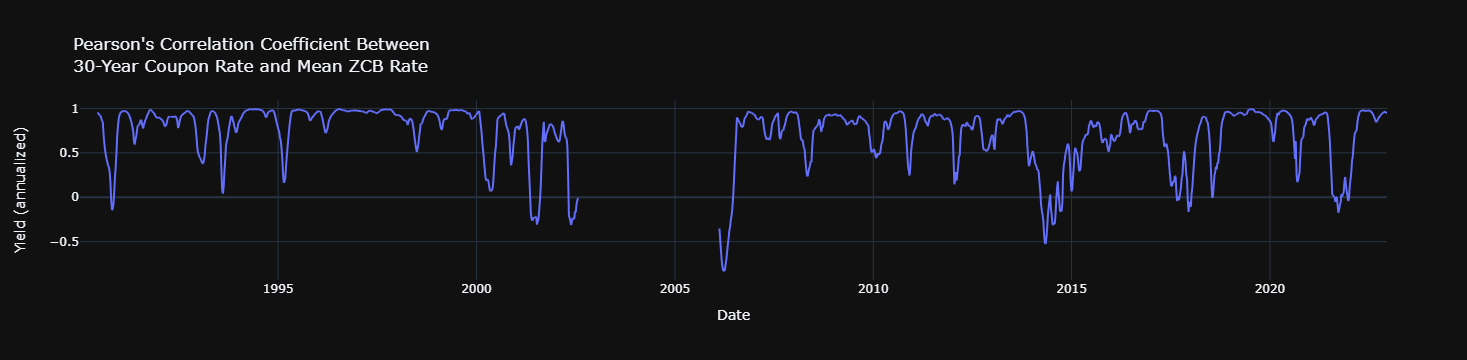

In [107]:
fig = px.line(
    mean_vs_30_yc['usa_30y'].rolling(24).corr(mean_vs_30_yc['mean_zcb']),
    template=plotly_template,
    labels={
        'value': 'Yield (annualized)',
        'index': 'Date',
    },
    title="Pearson's Correlation Coefficient Between<br>30-Year Coupon Rate and Mean ZCB Rate",
)
fig.update_layout(showlegend=False)
fig

As expected, the mean of 1, 3, and 5 year ZCB rates correlates strongly with interest rates overall, for which we use the 30-year coupon rate as a proxy.

# Strategy 2-A Preliminary Analysis

For this strategy, the signal is a significant deviation in the difference between the slopes of two adjacent sections of the yield curve. As an example in our preliminary analysis, we calculate the slope of the curve between 3 and 5-year T-notes, and between 1 and 3-year notes:

In [112]:
slope_35 = (uszcb['usa_5y_zcb'] - uszcb['usa_3y_zcb']) / (5 - 3)
slope_13 = (uszcb['usa_3y_zcb'] - uszcb['usa_1y_zcb']) / (3 - 1)
slope_diff = slope_35 - slope_13
slope_diff.head(3)

1990-01-03    0.000053
1990-01-10   -0.000274
1990-01-17   -0.000183
dtype: float64

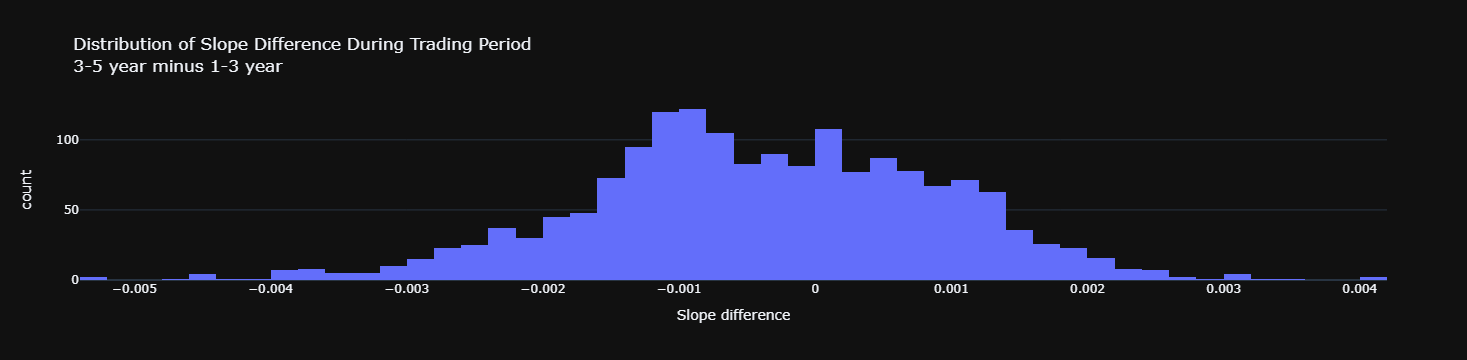

In [116]:
fig = px.histogram(
    slope_diff,
    template=plotly_template,
    labels={
        'count': 'Count',
        'value': 'Slope difference',
    },
    title='Distribution of Slope Difference During Trading Period<br>3-5 year minus 1-3 year',
)
fig.update_layout(showlegend=False)
fig

# Scratch